In [1]:
import pickle
import matplotlib.pyplot as plt
# Replace 'your_file.pkl' with the actual path to your pickle file
with open('SimulationResults/SensitivityAnalysis/SOBOL_analysis_1747066780.pickle', 'rb') as f:
    sensitivity_data = pickle.load(f)

# Display the loaded data (optional)
print("Sensitivity Analysis Data:")
print(sensitivity_data.keys())
# print(sensitivity_data['t_values'])
print(sensitivity_data['seed'])
print(sensitivity_data['number_variables'])
print(sensitivity_data['parameter_names'])
print(sensitivity_data['parameter_value_bounds'])
print(sensitivity_data['problem_spec'])
print(sensitivity_data['t_eval_steps'])
print(sensitivity_data['y_final'])
print(sensitivity_data['y_avg'])
print(sensitivity_data['y_var'])
print(sensitivity_data['final_analyzed'])


Sensitivity Analysis Data:
dict_keys(['seed', 'number_variables', 'parameter_names', 'parameter_value_bounds', 'problem_spec', 't_eval_steps', 't_values', 'y_values', 'y_final', 'y_avg', 'y_var', 'final_analyzed', 'avg_analyzed', 'var_analyzed', 'SOBOL_2nd_order', 'SOBOL_number_samples', 'SOBOL_number_samples_tested', 'data_size', 'graph_data_keys', 'graph_data', 'non_graph_data_vector', 'non_graph_data_matrix', 'settings', 'environment_data', 'other_parameters'])
0
10
['Resources', 'Uninfected Bacteria', 'Phages', 'e_vector', 'tau_vector', 'v_matrix', 'K_matrix', 'r_matrix', 'B_matrix', 'washout']
[[10.0, 500.0], [1.0, 300.0], [1.0, 100.0], [0.08, 0.25], [0.4, 3.5], [0.5, 2.3], [1.0, 100.0], [0.0, 0.2], [1.0, 100.0], [0.0, 0.05]]
ProblemSpec does not currently contain any samples, evaluations or results.
200
[[ 70.70903437   0.           0.         238.76086372   0.        ]
 [ 73.67225583   0.           0.         238.84682651   0.        ]
 [ 66.82952416   0.           0.         24

In [ ]:
def create_sobol_plot(analyzed, parameter_names, title):
    fig, axs = plt.subplots(len(analyzed), 2, figsize=(10, 10))
    fig.suptitle(f'Total and First Order Sobol Sensitivity Analysis for {title} Value of Simulation for Phages, \n Uninfected Bacteria, Infected Bacteria, Phages, and Bacteria Sum', fontsize=16)
    list_of_output = ['Resources', 'Uninfected', 'Infected', 'Phages', 'Total Bacteria']
    for i, analyzed_item in enumerate(analyzed):
        St = analyzed_item['ST']
        St_conf = analyzed_item['ST_conf']
        axs[i, 0].bar(parameter_names, St, yerr=St_conf, capsize=5)
        axs[i, 0].set_ylabel('Total Sensitivity\n(ST)')
        if i == len(analyzed) - 1:
            axs[i, 0].set_xticks(range(len(parameter_names)))
            axs[i, 0].set_xticklabels(parameter_names, rotation=45, ha='right')
            axs[i, 0].set_xlabel('Parameter Names')
        else: 
            axs[i, 0].set_xticks([])
        axs[i, 0].set_title(f'Total Sobol Indices for {list_of_output[i]}')

    for i, analyzed_item in enumerate(analyzed):
        S1 = analyzed_item['S1']
        S1_conf = analyzed_item['S1_conf']
        axs[i, 1].bar(parameter_names, S1, yerr=S1_conf, capsize=5)
        axs[i, 1].set_ylabel('Local Sensitivity\n(S1)')
        axs[i, 1].set_title(f'First-order Sobol Indices for {list_of_output[i]} (y_final)')
        if i == len(analyzed) - 1:
            axs[i, 1].set_xticks(range(len(parameter_names)))
            axs[i, 1].set_xticklabels(parameter_names, rotation=45, ha='right')
            axs[i, 1].set_xlabel('Parameter Names')
        else: 
            axs[i, 1].set_xticks([])
    fig.tight_layout()


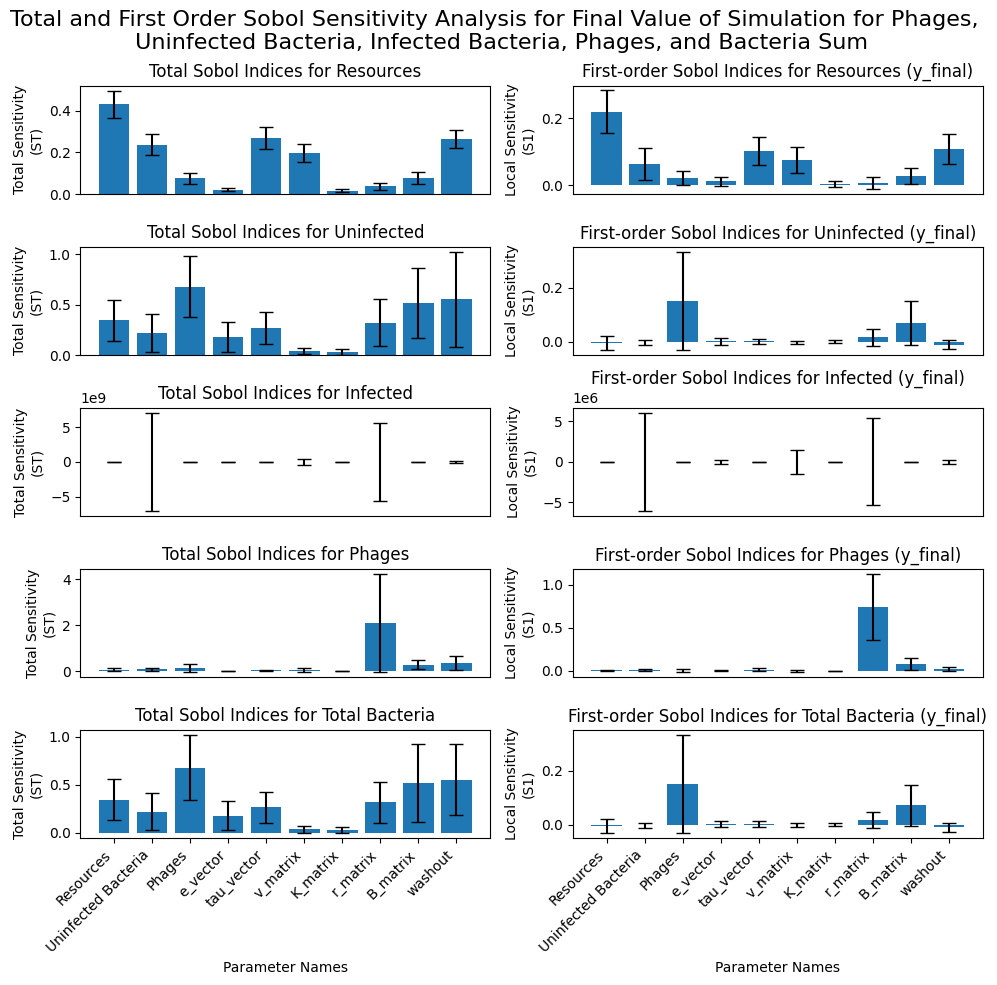

In [ ]:
parameter_names = sensitivity_data['parameter_names']
final_analyzed = sensitivity_data['final_analyzed']
create_sobol_plot(final_analyzed, parameter_names, "Final")

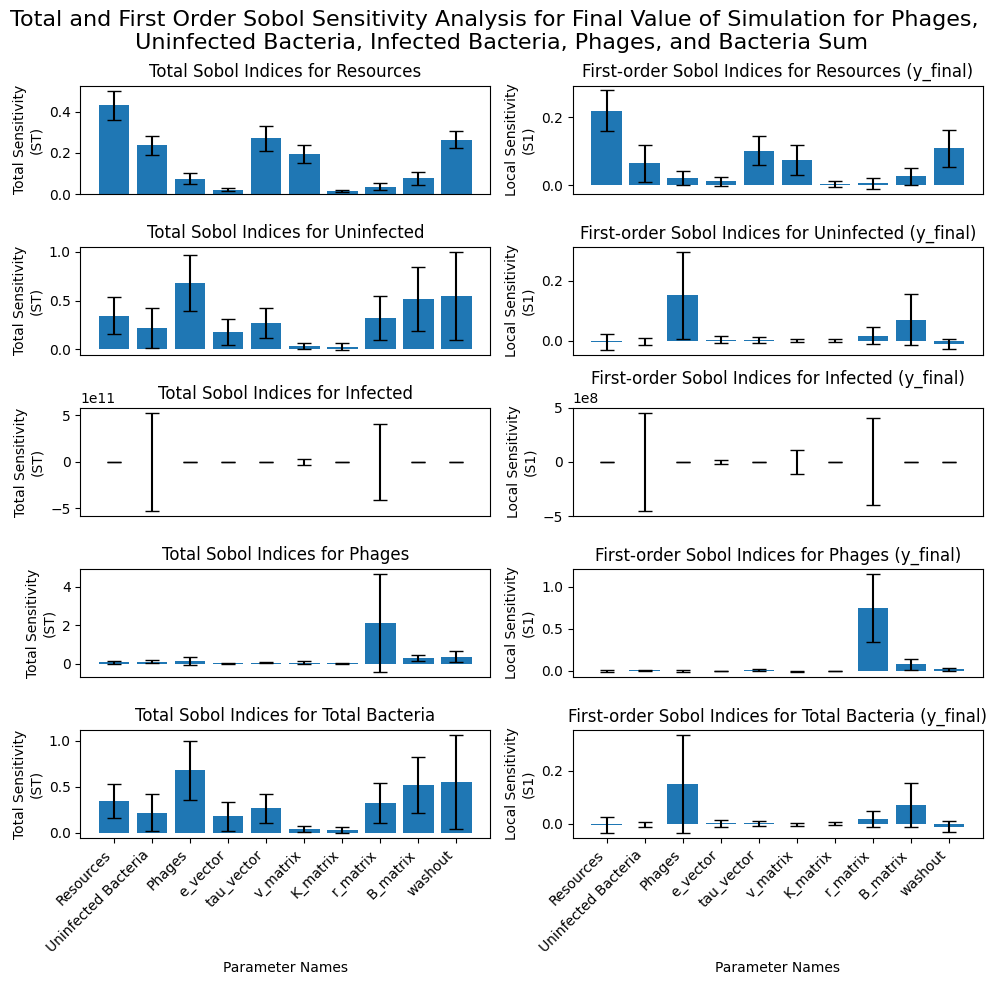

In [ ]:
parameter_names = sensitivity_data['parameter_names']
final_analyzed = sensitivity_data['var_analyzed']
create_sobol_plot(final_analyzed, parameter_names, "Variance")

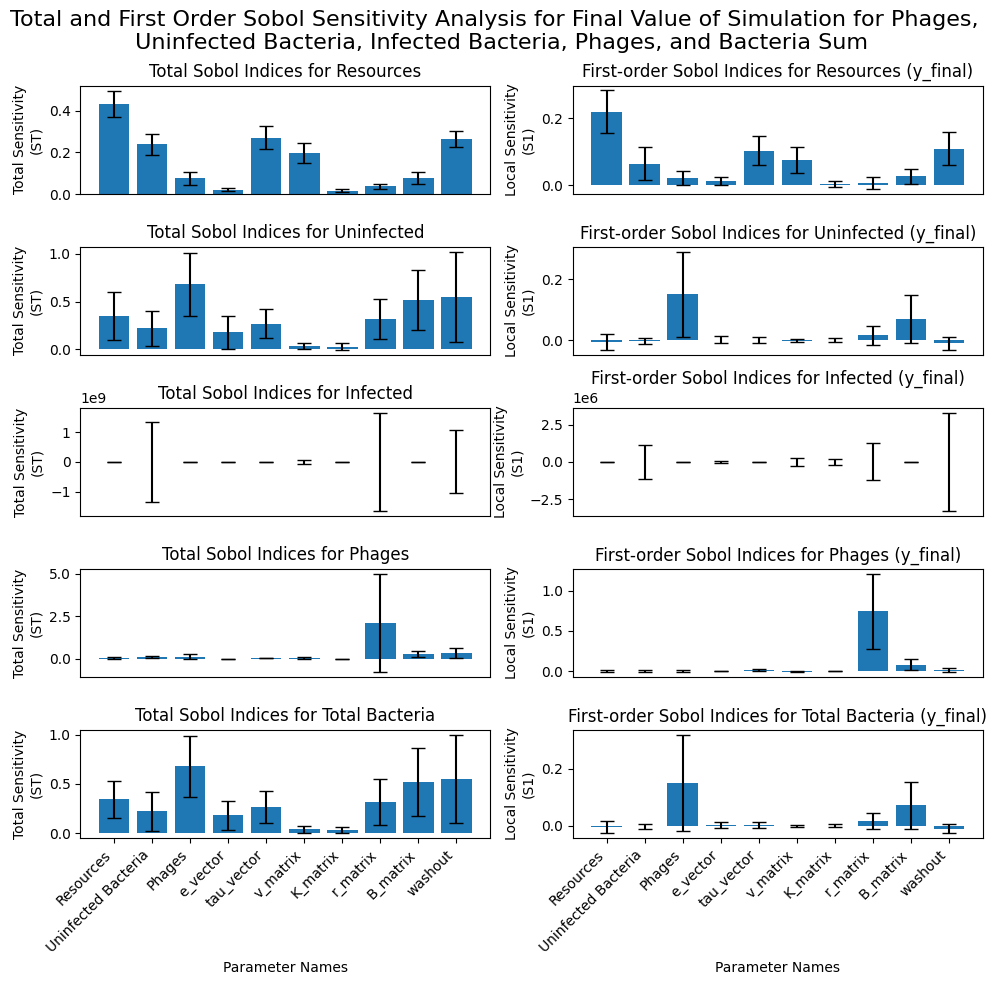

In [ ]:
parameter_names = sensitivity_data['parameter_names']
final_analyzed = sensitivity_data['avg_analyzed']
create_sobol_plot(final_analyzed, parameter_names, "Average")